In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()
ss = SparkSession.builder.getOrCreate()

In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
from datetime import datetime
from pyspark.sql import Row

In [4]:
def toTimeSafe(inval):
  try:
    return datetime.strptime(inval, "%d-%b-%y %I.%M.%S %p")
  except ValueError:
    return None

def toFloatSafe(inval):
  try:
    return float(inval)
  except ValueError:
    return None

In [5]:
### Only use this when using 'Irving2200_1month.csv'
def stringToPost(row):
  r = row.split(",")
  return Row(
    r[1].lstrip('\"').rstrip('\"'),r[2].lstrip('\"').rstrip('\"'),
    r[3].lstrip('\"').rstrip('\"'),
    toTimeSafe(r[4].lstrip('\"').rstrip('\"')),
    toTimeSafe(r[5].lstrip('\"').rstrip('\"')),
    r[6].lstrip('\"').rstrip('\"'), r[7].lstrip('\"').rstrip('\"')
    )


In [65]:
### Don't use this when using 'Irving2200_1month.csv'

def stringToPost(row):
  r = row.split(",")
  return Row(
    r[0].lstrip('\"').rstrip('\"'),r[1].lstrip('\"').rstrip('\"'),
    r[2].lstrip('\"').rstrip('\"'),
    toTimeSafe(r[3].lstrip('\"').rstrip('\"')),
    toTimeSafe(r[4].lstrip('\"').rstrip('\"')),
    r[5].lstrip('\"').rstrip('\"'), r[6].lstrip('\"').rstrip('\"')
    )

In [66]:
dataset = sc.textFile('../Data/output1month.csv')
dataset = dataset.flatMap(lambda x: x.split('\n'))


In [67]:
dataset_1st = dataset.first()

In [68]:
dataset = dataset.filter(lambda x: x!= dataset_1st)
dataset.take(2)

['490-22190,IRVING ST 2200,CASH,19-OCT-18 11.00.01 AM,19-OCT-18 11.09.21 AM,NS,0.35',
 '823-00160,CHESTNUT ST 0,CASH,13-OCT-18 03.30.34 PM,13-OCT-18 04.33.25 PM,AT,0.05']

In [69]:
revenue = dataset.map(lambda x: stringToPost(x))

In [70]:
schema = StructType([ StructField("meter_id", StringType(), False),
                      StructField("block", StringType(), False),
                      StructField("payType", StringType(), False),
                      StructField("starttime", TimestampType(), False),
                      StructField("endtime", TimestampType(), False),
                      StructField("meterType", StringType(), False),
                      StructField("revenue", StringType(), False)
                    ])

In [71]:
revenue_df = ss.createDataFrame(revenue, schema)
revenue_df.show()

+---------+--------------------+-----------+-------------------+-------------------+---------+-------+
| meter_id|               block|    payType|          starttime|            endtime|meterType|revenue|
+---------+--------------------+-----------+-------------------+-------------------+---------+-------+
|490-22190|      IRVING ST 2200|       CASH|2018-10-19 11:00:01|2018-10-19 11:09:21|       NS|   0.35|
|823-00160|       CHESTNUT ST 0|       CASH|2018-10-13 15:30:34|2018-10-13 16:33:25|       AT|   0.05|
|490-21250|      IRVING ST 2100|       CASH|2018-10-29 12:40:30|2018-10-29 13:07:10|       NS|    1.0|
|440-37030|     GEARY BLVD 3700|CREDIT CARD|2018-10-30 13:36:13|2018-10-30 13:49:33|       NS|    0.5|
|540-00100|         LAGUNA ST 0|PAY BY CELL|2018-10-05 09:42:00|2018-10-05 10:12:00|       AT|   1.12|
|700-12080|    VALENCIA ST 1200|PAY BY CELL|2018-10-12 09:00:00|2018-10-12 10:35:00|       NS|   4.35|
|923-00001|Claremont and Ull...|CREDIT CARD|2018-10-26 11:30:54|2018-10-2

In [72]:
revenue_df = revenue_df.withColumn('revenue',revenue_df['revenue'].cast('float'))
revenue_df.printSchema()

root
 |-- meter_id: string (nullable = false)
 |-- block: string (nullable = false)
 |-- payType: string (nullable = false)
 |-- starttime: timestamp (nullable = false)
 |-- endtime: timestamp (nullable = false)
 |-- meterType: string (nullable = false)
 |-- revenue: float (nullable = true)



In [73]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, date_format, col

revenue_df = revenue_df.withColumn('starttime_date',date_format('starttime','yyyy-M-d'))
revenue_df = revenue_df.withColumn('starttime_hour',date_format('starttime','HH').cast('string'))
revenue_df = revenue_df.withColumn('dow',date_format('starttime','u').cast('string'))
revenue_df = revenue_df.withColumn('endtime_hour',date_format('endtime','HH').cast('string'))
revenue_df = revenue_df.withColumn('timeDiff', unix_timestamp('endtime')- unix_timestamp('starttime'))

revenue_df.drop('starttime','endtime').show()

+---------+--------------------+-----------+---------+-------+--------------+--------------+---+------------+--------+
| meter_id|               block|    payType|meterType|revenue|starttime_date|starttime_hour|dow|endtime_hour|timeDiff|
+---------+--------------------+-----------+---------+-------+--------------+--------------+---+------------+--------+
|490-22190|      IRVING ST 2200|       CASH|       NS|   0.35|    2018-10-19|            11|  5|          11|     560|
|823-00160|       CHESTNUT ST 0|       CASH|       AT|   0.05|    2018-10-13|            15|  6|          16|    3771|
|490-21250|      IRVING ST 2100|       CASH|       NS|    1.0|    2018-10-29|            12|  1|          13|    1600|
|440-37030|     GEARY BLVD 3700|CREDIT CARD|       NS|    0.5|    2018-10-30|            13|  2|          13|     800|
|540-00100|         LAGUNA ST 0|PAY BY CELL|       AT|   1.12|     2018-10-5|            09|  5|          10|    1800|
|700-12080|    VALENCIA ST 1200|PAY BY CELL|    

In [74]:
wanted_df = revenue_df.groupBy("block","dow","starttime_hour")\
                      .agg(avg('revenue').alias('avgRevenue'), 
                      count('starttime_hour').alias('numNewTrans'),
                      avg('timeDiff').alias('avgDur'),
                      count(when(col('meterType')=='NS', True)).alias('numNS'),
                      count(when(col('meterType')=='AT', True)).alias('numAT'),
                      count(when(col('payType')=='CASH', True)).alias('numCASH'),
                      count(when(col('payType')=='CREDIT CARD', True)).alias('numCC'),
                      count(when(col('payType')=='PAY BY CELL', True)).alias('numPhone'),
                      count(when(col('payType')=='SMART CARD', True)).alias('numSmartCard'))

In [75]:
wanted_df.show()

+------------------+---+--------------+------------------+-----------+------------------+-----+-----+-------+-----+--------+------------+
|             block|dow|starttime_hour|        avgRevenue|numNewTrans|            avgDur|numNS|numAT|numCASH|numCC|numPhone|numSmartCard|
+------------------+---+--------------+------------------+-----------+------------------+-----+-----+-------+-----+--------+------------+
|      BROADWAY 100|  3|            10|3.6637500040233135|         32|            6322.5|   19|   13|      5|   22|       5|           0|
|  PRESIDIO AVE 500|  1|            12|1.3291666706403096|         12|2544.3333333333335|   10|    2|      5|    7|       0|           0|
|   TARAVAL ST 1400|  6|            11| 1.352978728711605|         47|2936.6382978723404|   36|   11|     20|   22|       5|           0|
|    CLEMENT ST 300|  2|            09|1.0331168803204964|         77| 2243.753246753247|   66|   11|     49|   18|       6|           4|
|     TAYLOR ST 600|  1|          

In [76]:
wanted_df_derv = revenue_df.groupBy("block","dow","endtime_hour").count()
wanted_df_derv = wanted_df_derv.withColumnRenamed('block', 'block_derv')
wanted_df_derv = wanted_df_derv.withColumnRenamed('dow', 'dow_derv')
wanted_df_derv.sort("dow","endtime_hour", ascending=[True, True]).show()

+--------------------+--------+------------+-----+
|          block_derv|dow_derv|endtime_hour|count|
+--------------------+--------+------------+-----+
|California and St...|       1|          00|    4|
|      MISSION ST 500|       1|          00|    1|
| LEAVENWORTH ST 2800|       1|          00|    2|
|      HOWARD ST 1600|       1|          00|    1|
|      BRANNAN ST 500|       1|          00|    2|
|        BROADWAY 600|       1|          00|    2|
|       SUTTER ST 500|       1|          00|    2|
|      SHRADER ST 600|       1|          00|    1|
|     GEARY BLVD 1100|       1|          00|    2|
|      JEFFERSON ST 0|       1|          00|    1|
|        20TH ST 3500|       1|          00|    1|
|      TAYLOR ST 2600|       1|          00|    2|
|      INDIANA ST 900|       1|          00|    1|
|          BAY ST 500|       1|          00|    1|
|     LOMBARD ST 2200|       1|          00|    1|
|        ELLIS ST 400|       1|          00|    1|
|        BUSH ST 1200|       1|

In [77]:
wanted_df = wanted_df.join(wanted_df_derv, 
                           (wanted_df.block == wanted_df_derv.block_derv) &
                           (wanted_df.dow == wanted_df_derv.dow_derv) &
                           (wanted_df.starttime_hour == wanted_df_derv.endtime_hour)).drop('endtime_hour')


In [78]:
wanted_df = wanted_df.withColumnRenamed('count','numEndTrans')
wanted_df = wanted_df.withColumn('turnover', wanted_df['numNewTrans'] - wanted_df['numEndTrans'])

In [79]:
wanted_df = wanted_df.drop('block_derv','dow_derv').sort("block", "dow","starttime_hour", ascending=[True, True])
wanted_df.drop('block','avgRevenue','avgDur').show()

+---+--------------+-----------+-----+-----+-------+-----+--------+------------+-----------+--------+
|dow|starttime_hour|numNewTrans|numNS|numAT|numCASH|numCC|numPhone|numSmartCard|numEndTrans|turnover|
+---+--------------+-----------+-----+-----+-------+-----+--------+------------+-----------+--------+
|  1|            11|         14|   12|    2|      3|    4|       0|           7|         15|      -1|
|  1|            13|         14|   11|    3|      6|    3|       4|           1|         19|      -5|
|  1|            09|         13|   12|    1|      4|    2|       3|           4|         13|       0|
|  1|            07|          6|    6|    0|      2|    0|       0|           4|          2|       4|
|  1|            15|          2|    2|    0|      2|    0|       0|           0|          5|      -3|
|  1|            14|         12|   11|    1|      6|    5|       0|           1|         13|      -1|
|  1|            12|         11|   10|    1|      2|    5|       1|           3|  

In [31]:
wanted_df.select('dow').groupby('dow').count().show()

+---+-----+
|dow|count|
+---+-----+
|  7|    3|
|  3|   10|
|  5|   11|
|  6|   10|
|  1|    9|
|  4|   10|
|  2|    9|
+---+-----+



In [23]:
from pyspark.sql.window import Window

In [24]:
#wanted_df = wanted_df.withColumn("lagNumTrans", lag('numTrans', 1).over(Window.partitionBy('block','dow').orderBy('starttime_hour')))

In [25]:
wanted_df.sort("block","dow","starttime_hour", ascending=[True, True, True]).drop('block').show()

+---+--------------+------------------+-----------+------------------+-----+-----+-------+-----+--------+------------+-----------+--------+
|dow|starttime_hour|        avgRevenue|numNewTrans|            avgDur|numNS|numAT|numCASH|numCC|numPhone|numSmartCard|numEndTrans|turnover|
+---+--------------+------------------+-----------+------------------+-----+-----+-------+-----+--------+------------+-----------+--------+
|  1|            09|0.5331055917169737|        161| 950.0372670807453|  140|   21|    145|   14|       1|           1|        112|      49|
|  1|            10|0.6457740583273905|        239|1191.7238493723848|  179|   60|    194|   28|       1|          16|        207|      32|
|  1|            11|0.7498347087155196|        242|1484.4338842975208|  185|   57|    192|   38|       4|           8|        236|       6|
|  1|            12|0.8426605498572008|        218|1630.9908256880733|  167|   51|    157|   41|      10|          10|        218|       0|
|  1|            13|

In [26]:
wanted_df.printSchema()

root
 |-- block: string (nullable = false)
 |-- dow: string (nullable = false)
 |-- starttime_hour: string (nullable = false)
 |-- avgRevenue: double (nullable = true)
 |-- numNewTrans: long (nullable = false)
 |-- avgDur: double (nullable = true)
 |-- numNS: long (nullable = false)
 |-- numAT: long (nullable = false)
 |-- numCASH: long (nullable = false)
 |-- numCC: long (nullable = false)
 |-- numPhone: long (nullable = false)
 |-- numSmartCard: long (nullable = false)
 |-- numEndTrans: long (nullable = false)
 |-- turnover: long (nullable = false)



In [27]:
wanted_df = wanted_df.withColumn("id", monotonically_increasing_id())
wanted_df.drop('block','avgRevenue','avgDur').show()

+---+--------------+-----------+-----+-----+-------+-----+--------+------------+-----------+--------+-----------+
|dow|starttime_hour|numNewTrans|numNS|numAT|numCASH|numCC|numPhone|numSmartCard|numEndTrans|turnover|         id|
+---+--------------+-----------+-----+-----+-------+-----+--------+------------+-----------+--------+-----------+
|  1|            15|        238|  187|   51|    192|   30|       3|          13|        230|       8|          0|
|  1|            11|        242|  185|   57|    192|   38|       4|           8|        236|       6|          1|
|  1|            09|        161|  140|   21|    145|   14|       1|           1|        112|      49|          2|
|  1|            13|        193|  153|   40|    147|   36|       4|           6|        200|      -7|          3|
|  1|            10|        239|  179|   60|    194|   28|       1|          16|        207|      32|          4|
|  1|            12|        218|  167|   51|    157|   41|      10|          10|        

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
dow = [int(row.dow) for row in wanted_df.select('dow').collect()]
turnover = [int(row.turnover) for row in wanted_df.select('turnover').collect()]
starttime_hour = [int(row.starttime_hour) for row in wanted_df.select('starttime_hour').collect()]

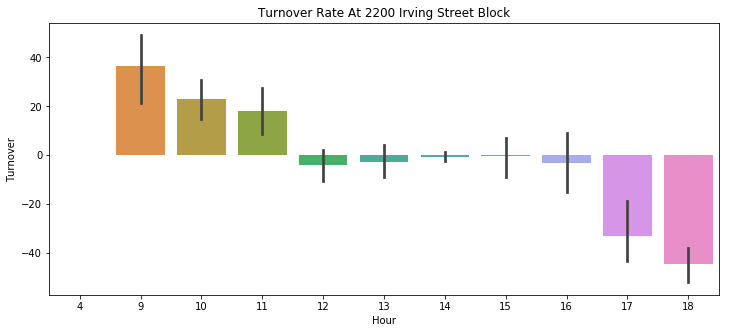

In [80]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x=starttime_hour, y=turnover, ax=ax)
ax.set_xlabel('Hour')
ax.set_ylabel('Turnover')
ax.set_title('Turnover Rate At 2200 Irving Street Block')
plt.show()

In [81]:
12*12

144

In [82]:
16/144

0.1111111111111111

In [85]:
44*60*.11

290.4

In [ ]:
wanted_df.select(avg('turnover')).show()